# Multi Layer Perceptron

Multilayer Perceptrons (MLPs) are a type of neural network architecture composed of fully connected layers. They are widely used for classification and regression tasks. Each neuron in an MLP takes input, applies a weight and bias, passes it through an activation function, and outputs a value to the next layer. For image classification, MLPs require input images to be flattened into vectors, making them less effective on raw image data compared to Convolutional Neural Networks (CNNs). However, with smaller datasets or simpler tasks, MLPs can still achieve good results.

### Installing libraries

In [1]:
!pip install tensorflow numpy matplotlib scikit-learn
!pip install imbalanced-learn

### Loading and Preprocessing Data

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = "C:/Users/moham/Desktop/Data Mining and ML/Processed Leaf Images"


## Define the Path to the Image Dataset

We set up the base path to the dataset directory. Ensuring the dataset is correctly imported. Must be run only after ImagePreProcessing.ipynb has processed the image folder

In [ ]:
# Set the base path to your image dataset
os.chdir('/Users/abdulr/Desktop/Abdul/F20DL_UG_Group_2/') # this should be changed to the path to local directory where the repository is saved
dataset_path= 'data/Preprocessed'

In [ ]:

image_size = (64, 64)  # Resize images to 64x64

#Looping through each folder to load images and labels
data = []
labels = []
class_names = os.listdir(dataset_path)

for label, folder in enumerate(class_names):
    folder_path = os.path.join(dataset_path, folder)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = load_img(image_path, target_size=image_size)
        image_array = img_to_array(image)   
        data.append(image_array)
        labels.append(label)

data = np.array(data)
labels = np.array(labels)


# Normalize the data
data = data / 255.0  # Normalize images to [0, 1] range

### Data balancing and augmentation using SMOTE

In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Flatten the image data for SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Reshape to [n_samples, n_features]

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape the resampled data back to the original image shape
X_resampled = X_resampled_flat.reshape(X_resampled_flat.shape[0], 64, 64, 3)

# One-hot encode the labels
y_resampled = to_categorical(y_resampled, num_classes=len(class_names))

# One-hot encode the test labels
y_test = to_categorical(y_test, num_classes=len(class_names))

# Augment the SMOTE-resampled training data 
train_datagen = ImageDataGenerator(
    rotation_range=40,  # Random rotation of up to 40 degrees
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill in missing pixels after transformations
)

# The test data should not be augmented, just normalized
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_resampled, y_resampled, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)


#### SMOTE visualization

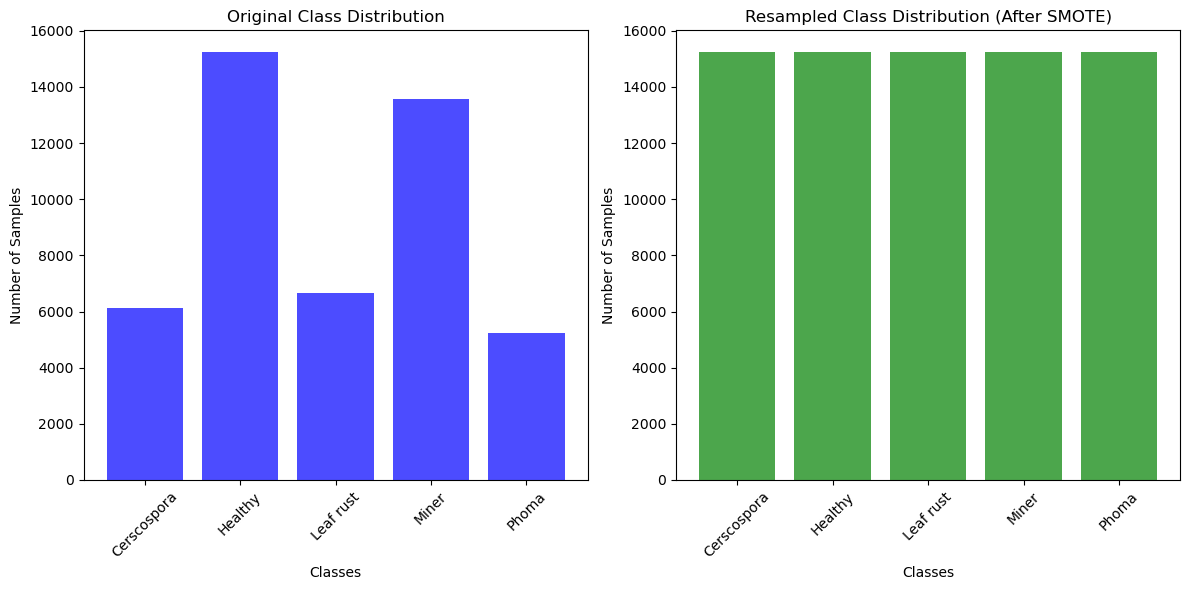

In [4]:
import matplotlib.pyplot as plt

# Original class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(class_names)), np.bincount(y_train), color='blue', alpha=0.7)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title("Original Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")

# Resampled class distribution
plt.subplot(1, 2, 2)
plt.bar(range(len(class_names)), np.bincount(np.argmax(y_resampled, axis=1)), color='green', alpha=0.7)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title("Resampled Class Distribution (After SMOTE)")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")

plt.tight_layout()
plt.show()


### Building the MLP model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
# Build the model
model = Sequential([
    Flatten(input_shape=(64, 64, 3)),  # Flatten 64x64x3 image into a vector
    Dense(128, activation='relu'),    # First hidden layer with 128 neurons
    Dense(64, activation='relu'),     # Second hidden layer with 64 neurons
    Dense(len(class_names), activation='softmax')  # Output layer for classification
])
sgd = SGD(learning_rate=0.01, momentum=0.9)  # Learning rate and momentum are tunable

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9  # Reduce learning rate by 10% after 5 epochs

lr_scheduler = LearningRateScheduler(scheduler)


C:\Users\moham\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,572,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,581,573 (6.03 MB)

 Trainable params: 1,581,573 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model over 10 epochs

In [6]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[lr_scheduler]  # Optional: Learning rate scheduler
)

C:\Users\moham\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.5896 - loss: 0.9466 - val_accuracy: 0.7397 - val_loss: 0.6186 - learning_rate: 0.0100
Epoch 2/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 90s 38ms/step - accuracy: 0.7178 - loss: 0.6710 - val_accuracy: 0.8477 - val_loss: 0.3881 - learning_rate: 0.0100
Epoch 3/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.7693 - loss: 0.5870 - val_accuracy: 0.8829 - val_loss: 0.2888 - learning_rate: 0.0100
Epoch 4/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.7991 - loss: 0.5299 - val_accuracy: 0.8519 - val_loss: 0.3635 - learning_rate: 0.0100
Epoch 5/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.8196 - loss: 0.4764 - val_accuracy: 0.8980 - val_loss: 0.2794 - learning_rate: 0.0100
Epoch 6/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 95s 40ms/step - accuracy: 0.8441 - loss: 0.4191 - val_accuracy: 0.9213 - val_loss: 0.2204 - learning_rate: 0.0090
Epoch 7/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accura

### Metrics

In [7]:
# Evaluate on the test set (no augmentation on test set)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9389 - loss: 0.1637
Test Accuracy: 94.16%


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


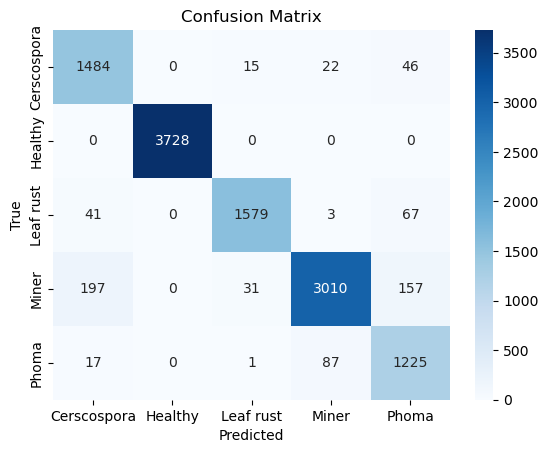

Classification Report:
              precision    recall  f1-score   support

 Cerscospora       0.85      0.95      0.90      1567
     Healthy       1.00      1.00      1.00      3728
   Leaf rust       0.97      0.93      0.95      1690
       Miner       0.96      0.89      0.92      3395
       Phoma       0.82      0.92      0.87      1330

    accuracy                           0.94     11710
   macro avg       0.92      0.94      0.93     11710
weighted avg       0.95      0.94      0.94     11710



In [9]:

# Predict class probabilities and convert them to class labels
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, digits=2)
print("Classification Report:")
print(report)